# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [46]:
# Imports

import sys
!{sys.executable} -m pip install -U requests beautifulsoup4 python-dotenv pandas

import os, pathlib, datetime as dt
import requests
import pandas as pd
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [48]:
import os
from pathlib import Path
from datetime import datetime
import requests
import pandas as pd
from dotenv import load_dotenv
load_dotenv() 
API_KEY = os.getenv("ALPHA_VANTAGE_KEY")
SYMBOL  = "CME"  

assert API_KEY, "Missing ALPHA_VANTAGE_KEY in .env"
    
ROOT = Path("..").resolve()  
RAW  = ROOT / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

# ---------- request ----------
params = {
    "function": "TIME_SERIES_DAILY",    
    "symbol": SYMBOL,
    "outputsize": "compact",
    "apikey": API_KEY,
}

resp = requests.get("https://www.alphavantage.co/query", params=params, timeout=30)
resp.raise_for_status()
data = resp.json()

# Handle API errors / throttling messages
if "Error Message" in data:
    raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
if "Note" in data:
    raise RuntimeError(f"Alpha Vantage notice (likely rate limit): {data['Note']}")

ts_key = "Time Series (Daily)"
assert ts_key in data, f"Unexpected response keys: {list(data.keys())}"

# ---------- normalize ----------
df_api = pd.DataFrame(data[ts_key]).T
df_api.index.name = "date"
df_api = df_api.rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low":  "low",
    "4. close": "close",
    "5. volume": "volume",
})

# types + sort
num_cols = ["open", "high", "low", "close", "volume"]
df_api[num_cols] = df_api[num_cols].apply(pd.to_numeric, errors="coerce")
df_api = df_api.reset_index()
df_api["date"] = pd.to_datetime(df_api["date"])
df_api = df_api.sort_values("date").reset_index(drop=True)

# ---------- validate ----------
assert not df_api.empty, "API returned empty dataset — check symbol or connectivity"
assert set(num_cols).issubset(df_api.columns), f"Missing cols: {set(num_cols) - set(df_api.columns)}"

# ---------- save ----------
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
out_path = RAW / f"api_alphavantage_{SYMBOL}_{timestamp}.csv"
df_api.to_csv(out_path, index=False)
print("Saved:", out_path.as_posix())

df=df_api


Saved: /Users/yuyuezhu/bootcamp_carolina_zhu/project/data/raw/api_alphavantage_CME_20250826-1943.csv


## Option B: Synthetic Generator (Use if you don't have data ready)

## Feature Engineering

In [50]:
df = df.copy()
df['return'] = df['close'].pct_change()

# Features
df['lag_1'] = df['return'].shift(1)
df['roll_mean_5'] = df['return'].rolling(5).mean().shift(1)
df['roll_vol_5'] = df['return'].rolling(5).std().shift(1)

# Target
df['y_next_ret'] = df['return'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

df_feat = df.dropna().copy()

## Split

In [52]:
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

features = ['lag_1', 'roll_mean_5', 'roll_vol_5']

X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']   # regression target
y_tr_clf, y_te_clf = train['y_up'], test['y_up']               # classification target

## Pipeline + Model (Choose one track below)

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# define pipeline
reg = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# fit and predict
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)

# evaluation
mse = mean_squared_error(y_te_reg, pred)   # old API: no 'squared'
rmse = np.sqrt(mse)                        # RMSE = sqrt(MSE)
r2 = r2_score(y_te_reg, pred)

print("Regression RMSE:", rmse)
print("Regression R²:", r2)


Regression RMSE: 0.012949941849827628
Regression R²: -0.14118011653495355


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.40      0.60      0.48        10

    accuracy                           0.32        19
   macro avg       0.20      0.30      0.24        19
weighted avg       0.21      0.32      0.25        19



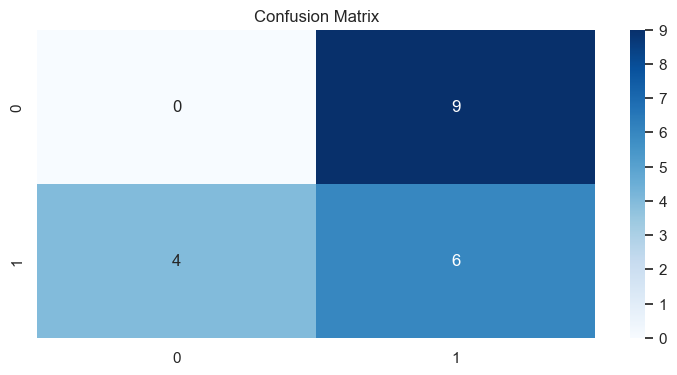

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=1000))
])

clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)

print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## Residual or prediction error analysis
- The logistic regression classifier struggled to distinguish between the two classes. Precision, recall, and F1-score for class 0 are all 0.00, showing the model completely failed to identify that class. For class 1, recall is moderate at 0.60, but precision is low at 0.40, indicating the model leaned heavily toward predicting class 1. The overall accuracy of 0.32 is only slightly above random guessing, suggesting the model is not capturing meaningful signals from the features.

## Explanation of Key Modeling Assumptions
- Linearity in log-odds: Logistic regression assumes a linear relationship between predictors and the log-odds of the target. Given the poor performance, this assumption may not hold for the dataset.

- Balanced classes: The dataset is small and imbalanced (9 vs 10 observations), which could amplify errors and bias predictions toward the majority or easier class.

- Independence: Observations may have temporal dependencies (since this is financial data), violating the independence assumption of logistic regression.